In [1]:
!pip install tensorflow==2.2.0

!pip install keras==2.3.1

!pip install -U segmentation-models==0.2.1
# # Hints:
# # zip : https://drive.google.com/file/d/1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ/view?usp=sharing
# # Compressed_zip : https://drive.google.com/file/d/1zHi5YxTl7c_svyjYaaX4qiDZSKnVUnfV/view?usp=sharing
# # 1. Don't normalize the mask values
# # 2. Don't augment the validation data
# # 3. while reading the image use this code

# # image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED) 
# # image = cv2.resize(image,(self.w,self.h),interpolation=cv2.INTER_AREA)
# # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# #  4. as the data is less try taking 0.1 to 0.15 % of the data as validation 
# # 5. Use ReLu activation function in the conv layers of CANET
# # 5. you can download this video : https://youtu.be/NVMWAMqgT-Y and then predict the masks for each frame(please check out the self driving car assignment), this is the example result of image segmentation 

     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 460kB 61.0MB/s 
     |████████████████████████████████| 3.0MB 53.3MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 378kB 9.9MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 81kB 6.6MB/s 


In [ ]:
!gdown --id "1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ"
# processed data
# !gdown --id "1zHi5YxTl7c_svyjYaaX4qiDZSKnVUnfV"
# !gdown --id "14w2vwbdGoRN7NffFz4IzdYFM-4GrfQnZ"
# !wget --header="Host: doc-04-7k-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.128 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8,la;q=0.7" --header="Referer: https://drive.google.com/" --header="Cookie: AUTH_e6r7g654r08n4c7rvpdb3hggohuuimpl_nonce=te668hnbgudoe" --header="Connection: keep-alive" "https://doc-04-7k-docs.googleusercontent.com/docs/securesc/ir88vhfas868utof5nd7gfa59g7jlumj/jp7elrk75bt9gdlovdlo8lvorpc0le9f/1618516800000/00484516897554883881/14748004131253493613/1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ?e=download&authuser=0&nonce=te668hnbgudoe&user=14748004131253493613&hash=q9a8fu6addqmrboufdp9ichlkqjgrdt7" -c -O 'data.zip'

Downloading...
From: https://drive.google.com/uc?id=1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ
To: /content/data.zip
2.34GB [00:11, 201MB/s]


In [ ]:
!unzip data.zip
# !rm -rf "data"
# !unzip "processed_data_segmentation.zip"

# Segmentation of Indian Traffic

In [2]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import pathlib

import urllib.request

import tensorflow as tf
# import tf.keras as keras 
# import tensorflow.keras as keras

from keras.callbacks import ModelCheckpoint


# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
# import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, LSTM, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model
import random as rn

Using TensorFlow backend.


<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [ ]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    image_paths = []
    mask_paths = []
    for scene_labels in sorted(os.listdir(root_dir+"data/images")):
      # images
      for img_path in sorted(os.listdir("data/images/"+scene_labels)):
        image_paths.append("data/images/"+scene_labels +"/"+img_path)
      # masks
      for img_path in sorted(os.listdir("data/mask/"+scene_labels)):
        mask_paths.append("data/mask/"+scene_labels +"/"+img_path)


    data_df = pd.DataFrame(data = {"image":image_paths, "json" : mask_paths})
    return data_df

In [ ]:
data_df = return_file_names_df("./")
data_df.head()

,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:

def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    unique_labels = set()
    for file_path in data_df["json"].values:
      with open(file_path,mode="r") as f:
        json_content = json.load(f)
        for obj in json_content["objects"]:
          unique_labels.add(obj["label"])

    return list(unique_labels)

In [ ]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}
len(label_clr)

40

In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image

    label = []
    vertexList = []
    w,h = 0,0
    with open(file,"r") as f:
      jsonFile = json.load(f)
      w,h = jsonFile["imgWidth"], jsonFile["imgHeight"]
      for obj in jsonFile["objects"]:
        label.append(obj["label"])

        # get polygons in format [(x,y),(x,y)]
        vertices = [(point[0],point[1]) for point in obj["polygon"]]
        vertexList.append(vertices)


    return w, h, label, vertexList

In [ ]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

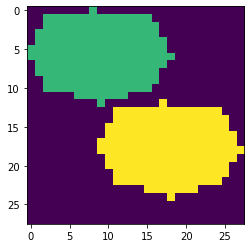

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)  # img1 is painter which paints on img (img is modified)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [ ]:
count = 0

def countInc():
  global count
  count += 1
  if count % 100 == 0:
    print(count)


def is_valid_cordinates(vList):
  for v in vList:
    if len(v) == 0:
      return False
  return True

# read file -> draw polygons -> save to file -> return path of saved mask_file
def draw_polygons_and_save_file(file_path):
  try:
    w,h, labels, vList = get_poly(file_path)
    img = Image.new("RGB", (w, h))
    img1 = ImageDraw.Draw(img)

    # some json have invalid cordinates
    if is_valid_cordinates(vList):
      for i,vertex in enumerate(vList):
        img1.polygon(vertex, fill = label_clr[labels[i]])
    
    #save image with polygons
    img=np.array(img)
    im = Image.fromarray(img[:,:,0])
    plt.imshow(img[:,:,0])

    # file path : data/mask/201/frame0029_gtFine_polygons.json -> data/output/201/frame0029_gtFine_polygons.png
    save_path = "data/output/"  + "/".join(file_path.split("/")[2:])
    save_png_path = save_path.split(".")[0]+".png"

    #check if directory exists (data/mask/sceneNo) else create
    dir_path = os.path.dirname(save_png_path)
    pathlib.Path(dir_path).mkdir(parents=True, exist_ok=True) #creates entire dir structue dir_path
  
    im.save(save_png_path)
  except Exception as e:
    print(file_path)
    print(e)

  # countInc()
  return save_png_path
  

In [ ]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])

    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    data_df["mask"] = data_df["json"].apply(lambda json_path : draw_polygons_and_save_file(json_path))

    return data_df

,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


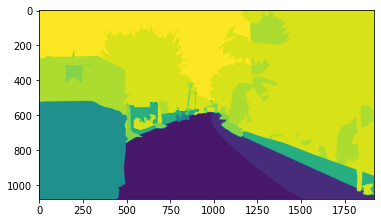

In [ ]:
# data_df_1 = compute_masks(data_df)
# data_df_1.head()

# data_df = pd.read_csv("/content/preprocessed_data_segmentation.csv")
data_df = compute_masks(data_df)
data_df.head(5)

False
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


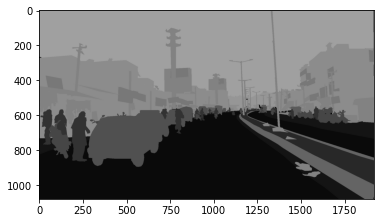

In [ ]:
def grader_3():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('data/output/201/frame0029_gtFine_polygons.png')    
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    # data_df_1.to_csv('preprocessed_data.csv', index=False)
grader_3()

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_df[["image","mask"]], test_size=0.10, random_state=42)

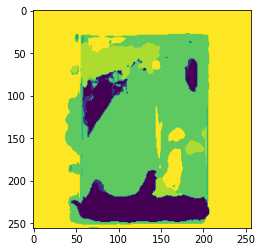

In [ ]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
model = Unet('resnet34', encoder_weights='imagenet', classes=21, activation='softmax', input_shape=(256,256,3))

In [ ]:
import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    
def normalize_image(mask):
    mask = mask/255
    return mask

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = list(label_clr.keys())
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, image_paths, mask_paths):
        
        # the paths of images
        self.image_paths = image_paths.values
        # the paths of segmentation images
        self.mask_paths = mask_paths.values
        # giving labels for each class
        self.class_values = list(range(1,22))
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.image_paths[i], cv2.IMREAD_UNCHANGED) 
        image = cv2.resize(image,(256,256),interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image_mask = cv2.imread(self.mask_paths[i], cv2.IMREAD_UNCHANGED)
        image_mask = cv2.resize(image_mask,(256,256),interpolation=cv2.INTER_AREA)
        image_mask = cv2.cvtColor(image_mask, cv2.COLOR_BGR2RGB)[:,:,0]
        image_mask = image_mask/10

        
        # image masks generate 21 matrices of size 256,256 where ele = 1 if mask_class else False
        # So you generate 21 mats of size 256,256 each
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float32')   # float caused error in running

        #image mask is 256,256,21 array where each element is a 21-dim vector 
        # in this 21-dim vector, we have one 1 and rest all 0s, the index of 1 indicate the mask label 
        a = np.random.uniform()
        if a<0.2:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.4:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.6:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        elif a<0.8:
            image = aug5.augment_image(image)
            image_mask = image_mask
        else:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.image_paths)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    try:
      def __init__(self, dataset, batch_size=1, shuffle=False):
          self.dataset = dataset
          self.batch_size = batch_size
          self.shuffle = shuffle
          self.indexes = np.arange(len(dataset))

      def __getitem__(self, i):
          
          # collect batch data
          start = i * self.batch_size
          stop = (i + 1) * self.batch_size
          data = []
          for j in range(start, stop):
              data.append(self.dataset[j])
          
          batch = [np.stack(samples, axis=0) for samples in zip(*data)]
          
          return tuple(batch)
      
      def __len__(self):
          return len(self.indexes) // self.batch_size
      
      def on_epoch_end(self):
          if self.shuffle:
              self.indexes = np.random.permutation(self.indexes)
    except Exception as e:
      print("LOADER ERROR")

In [ ]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet

optim = tf.keras.optimizers.Adam(0.001)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optimizer=optim, loss= focal_loss, metrics=[iou_score])

In [ ]:
# Dataset for train images
# CLASSES = ['edited']
train_dataset = Dataset(X_train["image"],X_train["mask"])
test_dataset  = Dataset(X_test["image"],X_test["mask"])

BATCH_SIZE=20
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)


callbacks = [
    ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_iou_score')
]

(20, 256, 256, 3)
(20, 256, 256, 21)


In [ ]:
# history = model.fit_generator(train_dataloader, epochs=10)
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=15,
    validation_data=test_dataloader,
    callbacks=callbacks)

Epoch 1/15
180/180 [==============================] - 297s 2s/step - loss: 1.7210 - iou_score: 0.1326 - val_loss: 1.3338 - val_iou_score: 0.2037
Epoch 2/15
180/180 [==============================] - 282s 2s/step - loss: 1.1113 - iou_score: 0.3657 - val_loss: 1.0308 - val_iou_score: 0.4214
Epoch 3/15
180/180 [==============================] - 280s 2s/step - loss: 0.8909 - iou_score: 0.4378 - val_loss: 0.9097 - val_iou_score: 0.4469
Epoch 4/15
180/180 [==============================] - 283s 2s/step - loss: 0.8146 - iou_score: 0.4555 - val_loss: 0.6647 - val_iou_score: 0.4636
Epoch 5/15
180/180 [==============================] - 287s 2s/step - loss: 0.7416 - iou_score: 0.4738 - val_loss: 0.6399 - val_iou_score: 0.4708
Epoch 6/15
180/180 [==============================] - 280s 2s/step - loss: 0.6967 - iou_score: 0.4869 - val_loss: 0.7462 - val_iou_score: 0.4833
Epoch 7/15
180/180 [==============================] - 279s 2s/step - loss: 0.6624 - iou_score: 0.4960 - val_loss: 0.6419 - val_iou

In [ ]:
import random

def condense_mask_layers(mask_arr):
  mask_image = np.array([[0]*256]*256)

  # condense 21 layers into 1
  for i in range(256):
    for j in range(256):
      mask_image[i][j] = np.argmax(mask_arr[i][j])+1

  return mask_image

def plot_predict_images_unet(n):
    idx = random.sample(range(len(test_dataset)),n)
    for i in idx:
      test_image, test_mask = test_dataset[i]
      pred_mask = model.predict(np.array([test_image]))[0]

      pred_mask_img = condense_mask_layers(pred_mask)
      test_mask_img = condense_mask_layers(test_mask)

     
      # plt.imshow(mask_image)
      plt.figure(figsize=(10,6))
      plt.subplot(131)
      plt.xlabel("Original Image")
      plt.imshow(test_image)
      plt.subplot(132)
      plt.xlabel("Original Mask")
      plt.imshow(test_mask_img)
      plt.subplot(133)
      plt.xlabel("Predicted Mask")
      plt.imshow(pred_mask_img)
      plt.show()

plot_predict_images_unet(20)

Output hidden; open in https://colab.research.google.com to view.


### Task 2.1: Dice loss

Explain the Dice loss
1. **Write the formualtion** <br>
![](https://miro.medium.com/max/514/1*EF3VCtk-VbTIKhriaQF0YQ.png)

  Dice Loss = 1 - Dice Score
  Where,
  - Pi => Predicted Pixel Value
  - Gi => Ground Truth Predicted Values
  - N => No of Pixels

2. **Range of the loss function** <br>
0 to 1

3. **Interpretation of loss function** <br>
- Basically Dice loss is the fraction of Correctly predicted boundaries to the total boundaries (predicted + ground truth)
- The denominator considers the total number of boundary pixels.
- The numerator considers the overlap between the two sets.


4. **Write your understanding of the loss function, how does it helps in segmentation**
- Used specifically for Boundary detection : So pixel values is either 0 (boundary pixel) or 1 (non boundary pixel)
- **Numerator** :  Sum of correctly predicted boundary pixels
- **Denominator** : Sum of total boundary pixels of both prediction and ground truth
- **Range** : 0->1


# Task 3: Training CANet

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv1D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [ ]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="conv_block"):
        super().__init__(name = name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride

        self.conv1 = Conv2D(self.F1, (1,1),padding='same')
        self.bn1 = BatchNormalization()
        self.act1 = Activation('relu')
        self.conv2 = Conv2D(self.F2, (3,3), strides=(self.stride,self.stride), padding='same') 
        self.bn2 = BatchNormalization()
        self.act2 = Activation('relu')
        self.conv3 = Conv2D(self.F3, (1,1),padding='same')
        self.bn3 = BatchNormalization()

        self.conv4 = Conv2D(self.F3, (3,3), strides=(self.stride,self.stride), padding='same') 
        self.bn4 = BatchNormalization()
        self.act4 = Activation('relu')

        self.output_layer = Add()

    def call(self, X):
        # write the architecutre that was mentioned above
        conv_1 = self.conv1 (X)
        bn_1 = self.bn1 (conv_1)
        act_1 = self.act1 (bn_1)
        conv_2 = self.conv2 (act_1)
        bn_2 = self.bn2 (conv_2)
        act_2 = self.act2 (bn_2)
        conv_3 = self.conv3 (act_2)
        bn_3 = self.bn3 (conv_3)

        # skip connection
        conv_4 = self.conv4 (X)
        bn_4 = self.bn4 (conv_4)
        act_4 = self.act4 (bn_4)

        # element wise addition
        output = self.output_layer([bn_3, act_4])
        
        return output

In [ ]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="id_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel

        self.conv1 = Conv2D(self.F1, (1,1),padding='same')
        self.bn1 = BatchNormalization()
        self.act1 = Activation('relu')
        self.conv2 = Conv2D(self.F2, (3,3), padding='same') 
        self.bn2 = BatchNormalization()
        self.act2 = Activation('relu')
        self.conv3 = Conv2D(self.F3, (1,1),padding='same')
        self.bn3 = BatchNormalization()

        self.output_layer = Add() 
        
    def call(self, X):
        # write the architecutre that was mentioned above
        conv_1 = self.conv1 (X)
        bn_1 = self.bn1 (conv_1)
        act_1 = self.act1 (bn_1)
        conv_2 =  self.conv2 (act_1)
        bn_2 = self.bn2 (conv_2)
        act_2 = self.act2 (bn_2)
        conv_3 = self.conv3(act_2)
        bn_3 = self.bn3 (conv_3)

        # skip connection
        output = self.output_layer ([bn_3,X])

        return output

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [ ]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, inp_shape, name="global_flow"):
        super().__init__(name=name)
        self.x_height = inp_shape[1]
        self.x_width = inp_shape[2]
        self.n_filters = inp_shape[-1]


        self.pool_layer = GlobalAveragePooling2D(data_format='channels_last')

        self.reshape_layer = Reshape((1,1,self.n_filters))
        self.bn_layer = BatchNormalization() 
        self.relu_layer= Activation('relu') 

        self.conv_layer = Conv2D(32,(1,1),padding='same')
        self.upsample_layer = UpSampling2D(size=(self.x_height,self.x_width), interpolation='bilinear') 



    def call(self, X):
        # implement the global flow operatiom
        # x_height = X.shape[1]
        # x_width = X.shape[2]

        pool = self.pool_layer (X)

        # GlobalPooling gives (none,last_layer) as output (1D) -> conv needs 2D
        reshape = self.reshape_layer (pool)
        bn = self.bn_layer  (reshape)
        relu = self.relu_layer (bn)

        conv = self.conv_layer (relu)
        upsample = self.upsample_layer (conv)

        return upsample

In [ ]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)
        self.N = 2

        self.concat_layer = Concatenate(axis = -1) 
        self.avgPool_layer = AveragePooling2D(pool_size= self.N) 
        self.conv_1 = Conv2D(32, kernel_size=(3,3), padding='same') 
        self.x_layer = Conv2D(32, kernel_size=(3,3), padding='same')

        # skip connection part
        self.conv_2 = Conv2D(32,kernel_size=(1,1), padding='same')
        self.relu_layer = Activation('relu') 
        self.conv_3 = Conv2D(32,kernel_size=(1,1), padding='same') 
        self.sigmoid_layer = Activation('sigmoid')

        # multiply
        self.mul_layer = Multiply()
        # add
        self.add_layer = Add() 
        self.upsample_layer = UpSampling2D(size=(self.N ,self.N), interpolation='bilinear') 


    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        N = 2
        # print("INP: ",INP.shape)
        # print("IN FLOW: ",FLOW.shape)

        concat = self.concat_layer ([INP, FLOW])
        avgPool = self.avgPool_layer (concat)
        conv1 = self.conv_1 (avgPool)
        x = self.x_layer (conv1)

        # skip connection part
        conv2 = self.conv_2 (x)
        relu = self.relu_layer (conv2)
        conv3 = self.conv_3 (relu)
        sigmoid = self.sigmoid_layer (conv3)

        # multiply
        mul = self.mul_layer ([x, sigmoid])
        # add
        add = self.add_layer ([mul, x])
        upsample = self.upsample_layer (add)

        # implement the context flow as mentioned in the above cell
        return upsample

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [ ]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, n_filters, name="fsm"):
        super().__init__(name=name)

        self.conv_layer = Conv2D(32, kernel_size=(3,3), padding='same') 
        self.pool_layer = GlobalAveragePooling2D(data_format='channels_last') 
        self.reshape_layer = Reshape((1,1,n_filters))
        self.conv_1 = Conv2D(32, kernel_size=(3,3), padding='same')
        self.bn_layer = BatchNormalization()
        self.act_layer = Activation('sigmoid')
        self.mul_layer = Multiply()
        self.upsample_layer = UpSampling2D(size=(2 , 2), interpolation='bilinear')
    def call(self, X):
        # implement the FSM modules based on image in the above cells
        conv = self.conv_layer (X)
        pool = self.pool_layer (conv)

        # GlobalPooling gives (none,last_layer) as output (1D) -> conv needs 2D
        reshape =self.reshape_layer (pool)

        conv1 = self.conv_1 (reshape)
        bn = self.bn_layer (conv1)
        sigmoid =  self.act_layer (bn)
        mul = self.mul_layer ([conv, sigmoid])

        # upsample to double the height and width
        upsample = self.upsample_layer (mul)


        return upsample

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [ ]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, n_filters, name="global_conv_net"):
        super().__init__(name=name)

        self.conv7x1_layer = Conv2D(filters=n_filters, kernel_size=(7,1),strides=(1,1), padding="same")
        self.conv1x7_layer = Conv2D(filters=n_filters, kernel_size=(1,7),strides=(1,1), padding="same")

        self.conv7x12_layer = Conv2D(filters=n_filters, kernel_size=(7,1),strides=(1,1), padding="same")
        self.conv1x72_layer = Conv2D(filters=n_filters, kernel_size=(1,7),strides=(1,1), padding="same")

        self.add_layer = Add() 

        self.conv3x3_layer = Conv2D(filters=n_filters, kernel_size=(3,3),strides=(1,1), padding="same")
        self.res_layer = Add() 
        
    def call(self, X):
        # please implement the above mentioned architecture

        conv7x1 = self.conv7x1_layer(X) 
        conv1x7 = self.conv1x7_layer(conv7x1) 

        conv7x12 = self.conv7x12_layer(X) 
        conv1x72 = self.conv1x72_layer(conv7x12) 

        add =  self.add_layer ([conv1x7, conv1x72])

        conv3x3 = self.conv3x3_layer(add) 
        res = self.res_layer ([conv3x3, add])

        return res

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [ ]:
# write the complete architecutre

input_image = Input(shape=(256,256,3))

# C0 - 2x
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(input_image)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

#C1 : reduce 4x
c1 = convolutional_block(kernel=3, filters=[4,4,32], stride=4, name="C1") (input_image)
c1_output = identity_block(kernel=3,  filters=[4,4,32], name="c1_output") (c1)

#C2 : reduce 8x
c2 = convolutional_block(kernel=3, filters=[8,8,16], stride=2, name="C2") (c1_output)
c2id1 = identity_block(kernel=3,  filters=[8,8,16], name="c2id1") (c2)
c2_output = identity_block(kernel=3,  filters=[8,8,16], name="c2_output") (c2id1)

#C3 : reduce 8x
c3 = convolutional_block(kernel=3, filters=[16,16,32], stride=1, name="C3") (c2_output)
c3id1 = identity_block(kernel=3,  filters=[16,16,32], name="c3id1") (c3)
c3id2 = identity_block(kernel=3,  filters=[16,16,32], name="c3id2") (c3id1)
c3_output = identity_block(kernel=3,  filters=[16,16,32], name="c3_output") (c3id2)

#C4 : reduce 8x
c4 = convolutional_block(kernel=3, filters=[32,32,64], stride=1, name="C4") (c3_output)
c4id1 = identity_block(kernel=3,  filters=[32,32,64], name="c4id1") (c4)
c4id2 = identity_block(kernel=3,  filters=[32,32,64], name="c4id2") (c4id1)
c4id3 = identity_block(kernel=3,  filters=[32,32,64], name="c4id3") (c4id2)
c4_output = identity_block(kernel=3,  filters=[32,32,64], name="c4_output") (c4id3)


global_flow_1 = global_flow(inp_shape=c4_output.shape, name="global_flow_1")(c4_output)
context_flow_1 = context_flow(name = "context_flow_1") ([c4_output, global_flow_1])
context_flow_2 = context_flow(name = "context_flow_2") ([c4_output, context_flow_1])
context_flow_3 = context_flow(name = "context_flow_3") ([c4_output, context_flow_2])

sum = Add() ([global_flow_1,context_flow_1,context_flow_2,context_flow_3 ])

# FSM + x2 up
fsm_layer = fsm(n_filters=sum.shape[-1],name="fsm")(sum)

# agcn
agcn_layer = agcn(n_filters=c1_output.shape[-1], name="agcn_layer") (c1_output)

# last step
concat = Concatenate(axis=-1) ([fsm_layer, agcn_layer])
convLast = Conv2D(filters=21, kernel_size=(3,3), padding='same', activation='relu') (concat) 
#upsample x4
upsampleLast = UpSampling2D(size=(4,4))(convLast)
sigmoid = Activation('softmax') (upsampleLast)

model1 = Model(inputs = input_image, outputs = sigmoid)

model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
C1 (convolutional_block)        (None, 64, 64, 32)   1508        input_5[0][0]                    
__________________________________________________________________________________________________
c1_output (identity_block)      (None, 64, 64, 32)   600         C1[0][0]                         
__________________________________________________________________________________________________
C2 (convolutional_block)        (None, 32, 32, 16)   5808        c1_output[0][0]                  
____________________________________________________________________________________________

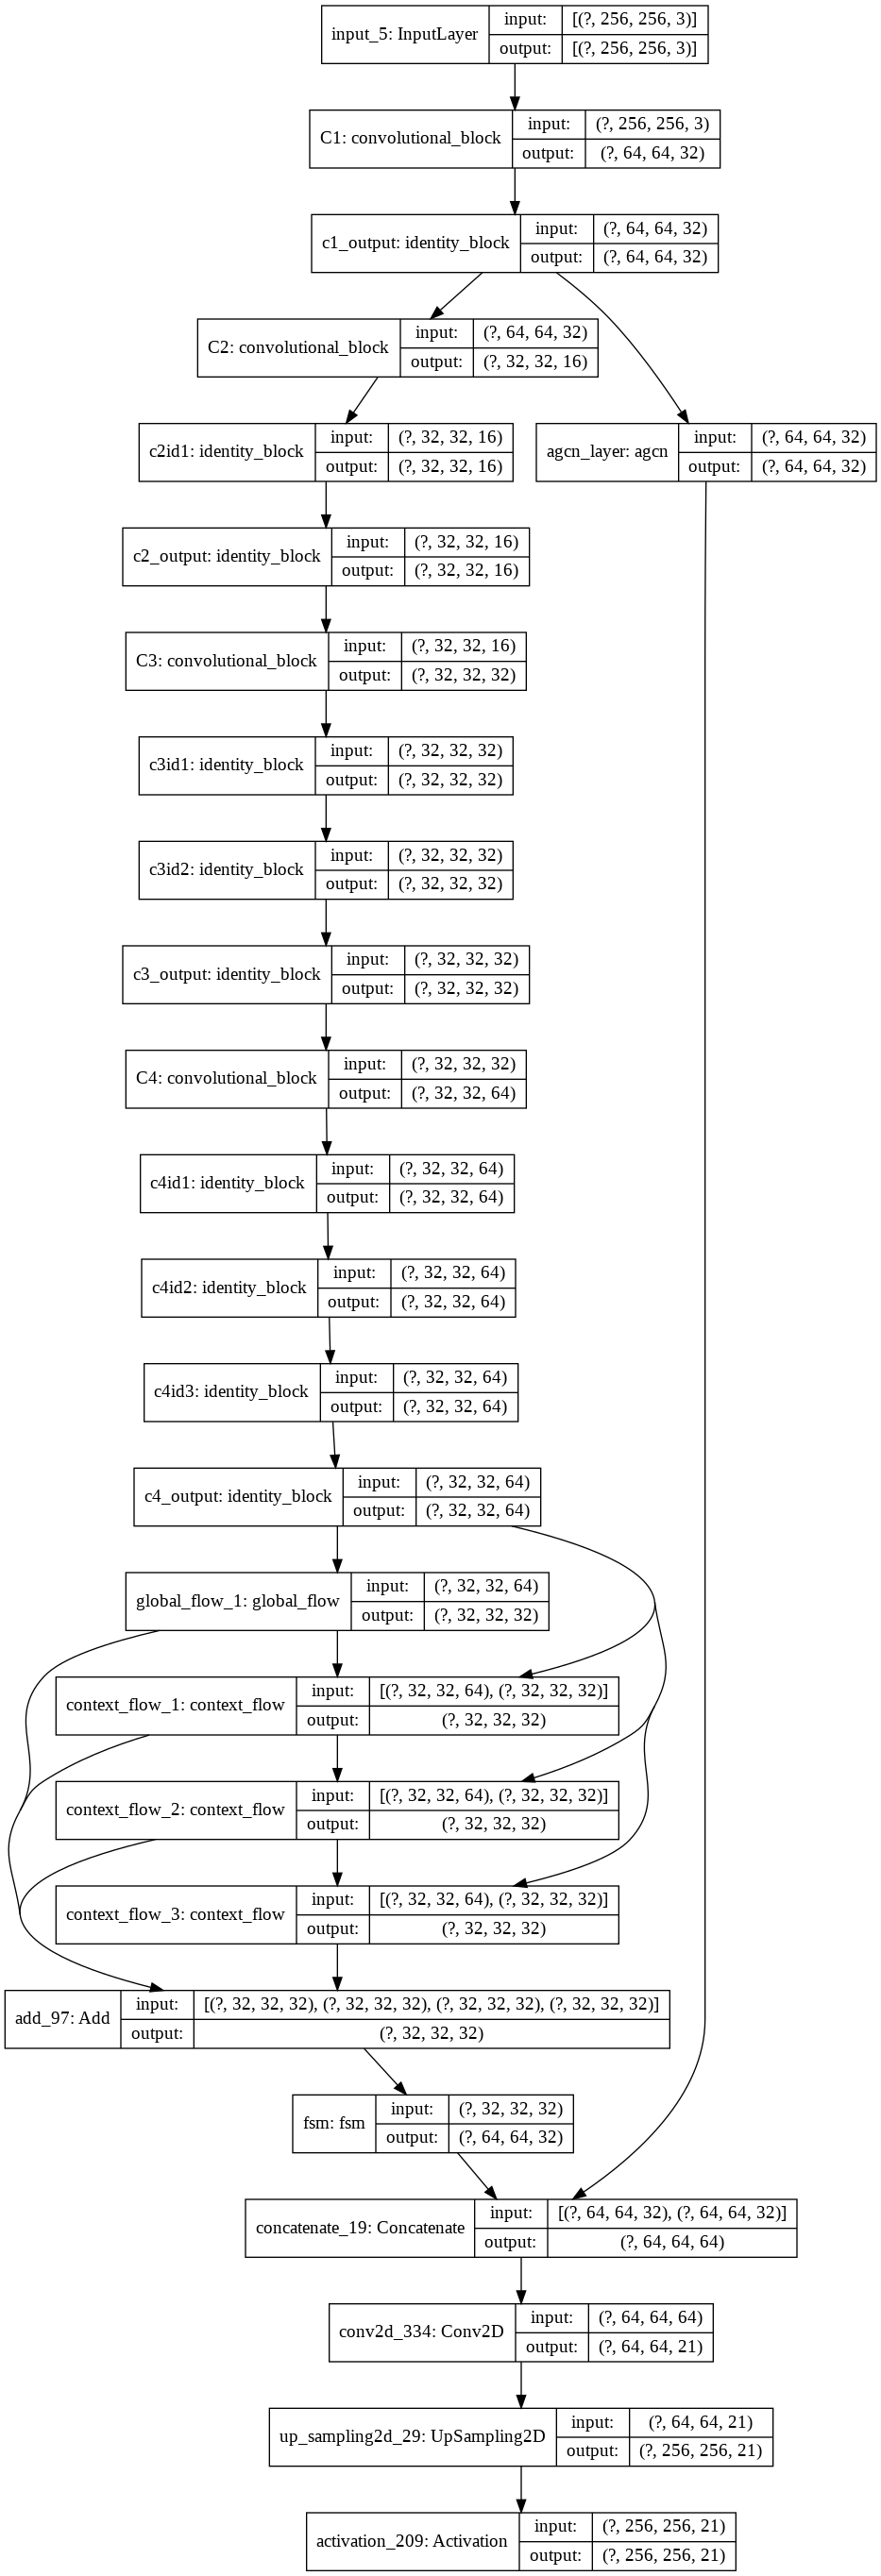

In [ ]:
tf.keras.utils.plot_model(
    model1, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [ ]:
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
optim = tf.keras.optimizers.Adam(0.001)
focal_loss = sm.losses.cce_dice_loss

model1.compile(optimizer='adam', loss= focal_loss, metrics=[iou_score])

In [ ]:
tf.config.experimental_run_functions_eagerly(True)
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test = train_test_split(data_df[["image","mask"]], test_size=0.10, random_state=42)
tf.keras.backend.set_image_data_format('channels_last')

aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    
def normalize_image(mask):
    mask = mask/255
    return mask

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = list(label_clr.keys())
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, image_paths, mask_paths):
        
        # the paths of images
        self.image_paths = image_paths.values
        # the paths of segmentation images
        self.mask_paths = mask_paths.values
        # giving labels for each class
        self.class_values = list(range(1,22))
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.image_paths[i], cv2.IMREAD_UNCHANGED) 
        image = cv2.resize(image,(256,256),interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image_mask = cv2.imread(self.mask_paths[i], cv2.IMREAD_UNCHANGED)
        image_mask = cv2.resize(image_mask,(256,256),interpolation=cv2.INTER_AREA)
        image_mask = cv2.cvtColor(image_mask, cv2.COLOR_BGR2RGB)[:,:,0]
        image_mask = image_mask/10

        
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float32')   # float caused error in running
   
        a = np.random.uniform()
        if a<0.2:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.4:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.6:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        elif a<0.8:
            image = aug5.augment_image(image)
            image_mask = image_mask
        else:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.image_paths)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    try:
      def __init__(self, dataset, batch_size=1, shuffle=False):
          self.dataset = dataset
          self.batch_size = batch_size
          self.shuffle = shuffle
          self.indexes = np.arange(len(dataset))

      def __getitem__(self, i):
          
          # collect batch data
          start = i * self.batch_size
          stop = (i + 1) * self.batch_size
          data = []
          for j in range(start, stop):
              data.append(self.dataset[j])
          
          batch = [np.stack(samples, axis=0) for samples in zip(*data)]
          
          return tuple(batch)
      
      def __len__(self):
          return len(self.indexes) // self.batch_size
      
      def on_epoch_end(self):
          if self.shuffle:
              self.indexes = np.random.permutation(self.indexes)
    except Exception as e:
      print("LOADER ERROR")

# Dataset for train images
# CLASSES = ['edited']
train_dataset = Dataset(X_train["image"],X_train["mask"])
test_dataset  = Dataset(X_test["image"],X_test["mask"])

BATCH_SIZE=32
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(32, 256, 256, 3)
(32, 256, 256, 21)


In [ ]:
!rm -rf models/*

In [ ]:
# history = model.fit_generator(train_dataloader, epochs=10)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath="models/CANET_Phase_4_{epoch:04d}.hdf5",
  verbose=1,
  save_weights_only=True,
  period=5)

history1 = model1.fit_generator(
    train_dataloader, 
    epochs=15,
    callbacks = [cp_callback])

Epoch 1/15
112/112 [==============================] - 278s 2s/step - loss: 2.4071 - iou_score: 0.0955
Epoch 2/15
112/112 [==============================] - 280s 2s/step - loss: 1.9252 - iou_score: 0.1189
Epoch 3/15
112/112 [==============================] - 279s 2s/step - loss: 1.7368 - iou_score: 0.1340
Epoch 4/15
112/112 [==============================] - 280s 3s/step - loss: 1.5780 - iou_score: 0.2583
Epoch 5/15
112/112 [==============================] - ETA: 0s - loss: 1.3556 - iou_score: 0.3795
Epoch 00005: saving model to models/CANET_Phase_4_0005.hdf5
112/112 [==============================] - 283s 3s/step - loss: 1.3556 - iou_score: 0.3795
Epoch 6/15
112/112 [==============================] - 281s 3s/step - loss: 1.3029 - iou_score: 0.3867
Epoch 7/15
112/112 [==============================] - 283s 3s/step - loss: 1.2703 - iou_score: 0.3930
Epoch 8/15
112/112 [==============================] - 284s 3s/step - loss: 1.2520 - iou_score: 0.3956
Epoch 9/15
112/112 [==================

In [ ]:
import random

def condense_mask_layers(mask_arr):
  mask_image = np.array([[0]*256]*256)

  # condense 21 layers into 1
  for i in range(256):
    for j in range(256):
      mask_image[i][j] = np.argmax(mask_arr[i][j])+1

  return mask_image

def plot_predict_images_canet(n):
    idx = random.sample(range(len(test_dataset)),n)
    for i in idx:
      test_image, test_mask = test_dataset[i]
      pred_mask = model1.predict(np.array([test_image]))[0]

      pred_mask_img = condense_mask_layers(pred_mask)
      test_mask_img = condense_mask_layers(test_mask)

     
      # plt.imshow(mask_image)
      plt.figure(figsize=(10,6))
      plt.subplot(131)
      plt.xlabel("Original Image")
      plt.imshow(test_image)
      plt.subplot(132)
      plt.xlabel("Original Mask")
      plt.imshow(test_mask_img)
      plt.subplot(133)
      plt.xlabel("Predicted Mask")
      plt.imshow(pred_mask_img)
      plt.savefig('CANET.png')
      plt.show()

plot_predict_images_canet(20)

Output hidden; open in https://colab.research.google.com to view.

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

### Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations

In [ ]:
!jupyter nbconvert --to html "Segmentation_Assignment.ipynb"

[NbConvertApp] Converting notebook Segmentation_Assignment.ipynb to html
[NbConvertApp] Writing 5437884 bytes to Segmentation_Assignment.html


In [15]:
# !pip install pytube
# !pip install videosequence
# https://www.youtube.com/watch?v=NVMWAMqgT-Y

  Created wheel for videosequence: filename=videosequence-1.1.0-cp37-none-any.whl size=4904 sha256=229096be6ca67dd63aa8cfdef28ddf6d19c1fbdf03c302ada12941df80a57192
  Stored in directory: /root/.cache/pip/wheels/3b/9e/a0/082c42a3aeb627b15d94346cc105d093efe47d578741f4bb81
Successfully built videosequence


In [13]:
from pytube import YouTube
YouTube("https://www.youtube.com/watch?v=NVMWAMqgT-Y").streams.first().download()

'/content/2 min of Indian driving in traffic.mp4'

In [59]:
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
import random
import cv2
from google.colab.patches import cv2_imshow
tf.keras.backend.set_image_data_format('channels_last')


model = Unet('resnet34', encoder_weights='imagenet', classes=21, activation='softmax', input_shape=(256,256,3))
optim = tf.keras.optimizers.Adam(0.001)
focal_loss = sm.losses.cce_dice_loss
model.compile(optimizer=optim, loss= focal_loss, metrics=[iou_score])
model.load_weights("UNET_best_model.h5")

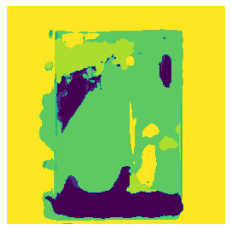

In [85]:
def condense_mask_layers(mask_arr):
  mask_image = np.array([[0]*256]*256)
  for i in range(256):
    for j in range(256):
      mask_image[i][j] = np.array([np.argmax(mask_arr[i][j])+1])

  return mask_image

def get_image(img):
    image = cv2.imread("foo_orig.png") 
    image = cv2.resize(image,(256,256),interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

pred_mask = model.predict(np.array([get_image("foo_orig.png")]))[0]
pred_mask_img = condense_mask_layers(pred_mask)

plt.imshow(pred_mask_img)
plt.axis(False)
plt.savefig("a.png")


KeyboardInterrupt: ignored

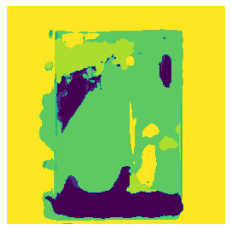

In [ ]:
# cap = cv2.VideoCapture("drive_video.mp4")
size = (256, 256)
result = cv2.VideoWriter('test.avi', cv2.VideoWriter_fourcc(*'MJPG'),10, size)

cap = cv2.VideoCapture("foo.mp4")
while(cap.isOpened()):
    ret , frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    
    pred_mask = model.predict(np.array([get_image(frame)]))[0]
    pred_mask_img = condense_mask_layers(pred_mask)
    plt.imshow(pred_mask_img)
    plt.axis(False)
    plt.savefig('frame.png')

    result.write(cv2.imread("frame.png"))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    
cap.release()
cv2.destroyAllWindows()

(288, 432, 3)


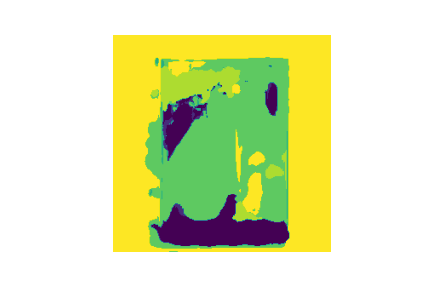

In [90]:
img = cv2.imread("TTT.png")
print(img.shape)
cv2_imshow(img)